In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from IPython.display import HTML
!pip install pydicom
!pip install celluloid
!pip install nibabel
from celluloid import Camera
import pydicom
import nibabel as nib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.3 MB/s eta 0:00:00


In [2]:
IMAGE_PATH = "/content/drive/MyDrive/Task02_Heart/imagesTr"
MASK_PATH = "/content/drive/MyDrive/Task02_Heart/labelsTr"

In [3]:
image_data = []
mask_data = []

for image in os.listdir(IMAGE_PATH):
  image = nib.load(os.path.join(IMAGE_PATH, image))
  image_data.append(image.get_fdata())

for mask in os.listdir(MASK_PATH):
  mask = nib.load(os.path.join(MASK_PATH, mask))
  mask_data.append(mask.get_fdata().astype(np.uint8))

print(len(image_data))
print(len(mask_data))

20
20


In [4]:
#the order of 3rd and 4th elements of mask data is incorrect, so swapping them
mask_data[3], mask_data[4] = mask_data[4], mask_data[3]

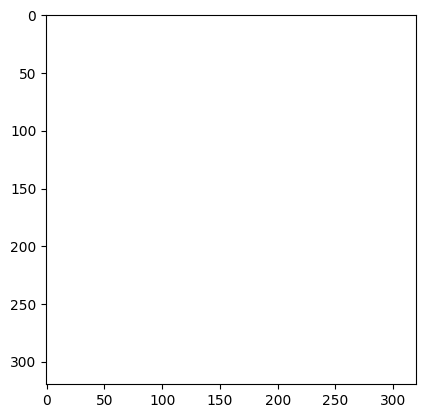

In [81]:
fig = plt.figure()
camera = Camera(fig)  # Create the camera object from celluloid

for i in range(image_data[3].shape[2]):  # Sagital view
    plt.imshow(image_data[3][:,:,i], cmap="bone")
    mask_ = np.ma.masked_where(mask_data[3][:,:,i]==0, mask_data[3][:,:,i])
    plt.imshow(mask_, alpha=0.5, cmap="autumn")
    # plt.axis("off")
    camera.snap()  # Store the current slice
animation = camera.animate()  # Create the animation




In [82]:
HTML(animation.to_html5_video())

In [83]:
def normalize_volume(volume):
    mu = np.mean(volume)
    sigma = np.std(volume)
    normalized_volume = (volume - mu) / sigma
    return normalized_volume

def standardize_volume(volume):
    min_val = np.min(volume)
    max_val = np.max(volume)
    standardized_volume = (volume - min_val) / (max_val - min_val)
    return standardized_volume

In [8]:
img = nib.load("/content/drive/MyDrive/Task02_Heart/imagesTr/la_003.nii.gz")
sample_img = img.get_fdata()

In [84]:
PREPROCESSED_PATH = "/content/drive/MyDrive/Task02_Heart/Preprocessed"

In [26]:
# from locale import normalize
# counter = 0
# for i in range(len(image_data)):

#   image_data[i] = image_data[i][32:-32,32:-32]
#   mask_data[i] = mask_data[i][32:-32,32:-32]

#   normalized_image_data = normalize_volume(image_data[i])
#   standardized_image_data = standardize_volume(normalized_image_data)

#   if counter < 16:
#     data_path = PREPROCESSED_PATH + "/train" + "/" + str(counter)
#   else:
#     data_path = PREPROCESSED_PATH + "/val" + "/" + str(counter)

#   counter += 1

#   for j in range(standardized_image_data.shape[-1]):
#         slice = standardized_image_data[:,:,j]
#         mask = mask_data[i][:,:,j]
#         slice_path = data_path + "/data"
#         mask_path = data_path + "/masks"

#         if not os.path.exists(slice_path):
#             os.makedirs(slice_path)
#         if not os.path.exists(mask_path):
#             os.makedirs(mask_path)

#         np.save(slice_path + "/" + str(j), slice)
#         np.save(mask_path + "/" + str(j), mask)


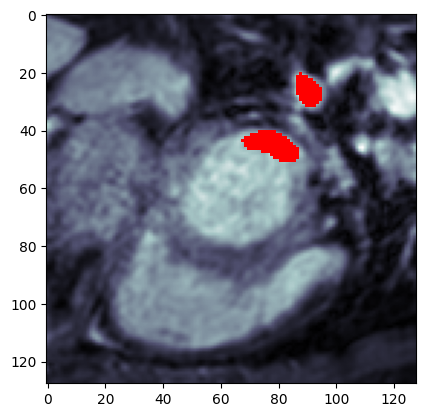

In [85]:
# visualizing preprocessed data

image_path = "/content/drive/MyDrive/Task02_Heart/Preprocessed/train/0/data/50.npy"
mask_path = "/content/drive/MyDrive/Task02_Heart/Preprocessed/train/0/masks/50.npy"

image = np.load(image_path)
mask = np.load(mask_path)

plt.figure()
plt.imshow(image, cmap="bone")
mask_ = np.ma.masked_where(mask==0, mask)
plt.imshow(mask_, cmap="autumn")

In [86]:
print(image.min(), image.max())

0.0 0.7908954477238619


In [87]:
import imgaug
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
import imgaug.augmenters as iaa


In [88]:
TRAIN_PATH = "/content/drive/MyDrive/Task02_Heart/Preprocessed/train"

In [89]:
class AtriumDataset(Dataset):

  def __init__(self,rootdir,transforms=None):
    self.img_paths, self.mask_paths = self.extract_paths(rootdir)
    self.transforms = transforms

  def extract_paths(self,rootdir):
    PREPROCESSED_IMG_PATH_LIST = []
    PREPROCESSED_MASK_PATH_LIST = []

    for subject in os.listdir(rootdir):
      subject_path = os.path.join(rootdir, subject)
      subject_data = subject_path + "/data"
      subject_masks = subject_path + "/masks"
      for slice in os.listdir(subject_data):
        slice_path = os.path.join(subject_data, slice)
        mask_path = os.path.join(subject_masks, slice)
        PREPROCESSED_IMG_PATH_LIST.append(slice_path)
        PREPROCESSED_MASK_PATH_LIST.append(mask_path)

    return PREPROCESSED_IMG_PATH_LIST, PREPROCESSED_MASK_PATH_LIST

  def augment(self, slice, mask):
    random_seed = torch.randint(0, 1000000, (1,)).item()
    imgaug.seed(random_seed)
    mask = SegmentationMapsOnImage(mask, mask.shape)
    slice_aug, mask_aug = self.transforms(image=slice, segmentation_maps=mask)
    mask_aug = mask_aug.get_arr()
    return slice_aug, mask_aug

  def __len__(self):
    return len(self.img_paths)

  def __getitem__(self,idx):
    img = np.load(self.img_paths[idx]).astype(np.float32)
    mask = np.load(self.mask_paths[idx])

    if self.transforms:
      img, mask = self.augment(img, mask)

    img = np.expand_dims(img, 0)
    mask = np.expand_dims(mask, 0)

    return img, mask



In [90]:
seq = iaa.Sequential([
    iaa.Resize((256, 256)),
    iaa.Affine(scale=(0.85, 1.15), # Zoom in or out
               rotate=(-45, 45)),  # Rotate up to 45 degrees
    iaa.ElasticTransformation()  # Random Elastic Deformations
                ])

In [91]:
train_dataset = AtriumDataset(TRAIN_PATH, transforms=seq)

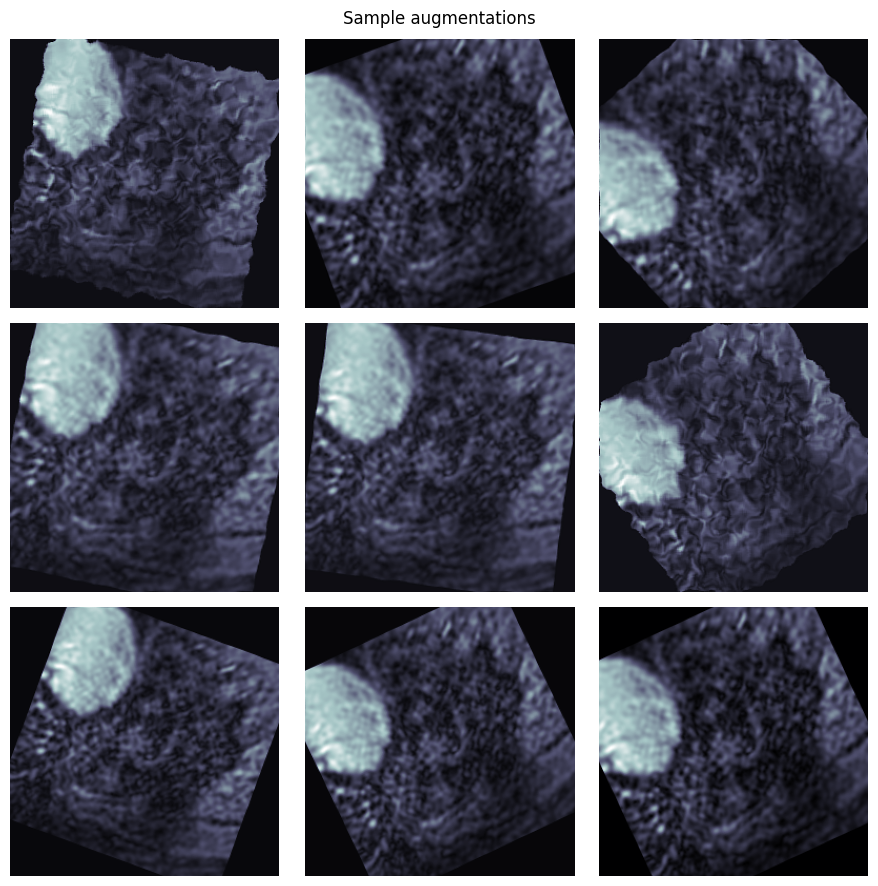

In [92]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))

for i in range(3):
    for j in range(3):
        slice, mask = train_dataset[3]
        mask_ = np.ma.masked_where(mask==0, mask)
        axis[i][j].imshow(slice[0], cmap="bone")
        axis[i][j].imshow(mask_[0], cmap="autumn")
        axis[i][j].axis("off")

fig.suptitle("Sample augmentations")
plt.tight_layout()


In [131]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DoubleConv, self).__init__()

    self.conv = nn.Sequential(nn.Conv2d(in_channels, out_channels, 3, padding=1),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                                nn.ReLU(inplace=True))

  def forward(self, x):
    return self.conv(x)


class UNetAtrium(nn.Module):
    def __init__(self):
        super(UNetAtrium, self).__init__()

        self.downconv1 = DoubleConv(1,64)
        self.downconv2 = DoubleConv(64,128)
        self.downconv3 = DoubleConv(128,256)
        self.downconv4 = DoubleConv(256,512)
        self.downconv5 = DoubleConv(512,1024)

        self.downsample = nn.MaxPool2d(2,2)

        self.upsample1 = nn.ConvTranspose2d(1024,512,2,2)
        self.upconv1 = DoubleConv(1024,512)

        self.upsample2 = nn.ConvTranspose2d(512,256,2,2)
        self.upconv2 = DoubleConv(512,256)

        self.upsample3 = nn.ConvTranspose2d(256,128,2,2)
        self.upconv3 = DoubleConv(256,128)

        self.upsample4 = nn.ConvTranspose2d(128,64,2,2)
        self.upconv4 = DoubleConv(128,64)

        self.finalconv = nn.Conv2d(64,1,1)

    def forward(self, x):

      x1 = self.downconv1(x)
      dsx1 = self.downsample(x1)
      x2 = self.downconv2(dsx1)
      dsx2 = self.downsample(x2)
      x3 = self.downconv3(dsx2)
      dsx3 = self.downsample(x3)
      x4 = self.downconv4(dsx3)
      dsx4 = self.downsample(x4)
      x5 = self.downconv5(dsx4)

      usx5 = self.upsample1(x5)
      usx5 = torch.cat([usx5, x4], dim=1)
      usx5 = self.upconv1(usx5)

      usx4 = self.upsample2(usx5)
      usx4 = torch.cat([usx4, x3], dim=1)
      usx4 = self.upconv2(usx4)

      usx3 = self.upsample3(usx4)
      usx3 = torch.cat([usx3, x2], dim=1)
      usx3 = self.upconv3(usx3)

      usx2 = self.upsample4(usx3)
      usx2 = torch.cat([usx2, x1], dim=1)
      usx2 = self.upconv4(usx2)

      output = self.finalconv(usx2)

      return output




In [165]:
model = UNetAtrium()

In [166]:
random_input = torch.randn(1, 1, 256, 256)
output = model(random_input)
print(output.shape)

torch.Size([1, 1, 256, 256])


In [167]:
class DiceLoss(torch.nn.Module):
    """
    class to compute the Dice Loss
    """
    def __init__(self):
        super().__init__()

    def forward(self, pred, mask):

        # Flatten label and prediction tensors
        pred = torch.flatten(pred)
        mask = torch.flatten(mask)
        counter = (pred * mask).sum()  # Numerator
        denum = pred.sum() + mask.sum() + 1e-8  # Denominator. Add a small number to prevent NANS
        dice =  (2*counter)/denum
        return 1 - dice


In [168]:
from ast import Num
PREPROCESSED_PATH_TRAIN = "/content/drive/MyDrive/Task02_Heart/Preprocessed/train"
PREPROCESSED_PATH_VAL = "/content/drive/MyDrive/Task02_Heart/Preprocessed/val"

seq = iaa.Sequential([
    iaa.Resize((256, 256)),
    iaa.Affine(scale=(0.85, 1.15), # Zoom in or out
               rotate=(-45, 45)),  # Rotate up to 45 degrees
    iaa.ElasticTransformation()  # Random Elastic Deformations
                ])

train_dataset = AtriumDataset(PREPROCESSED_PATH_TRAIN, transforms=seq)
val_dataset = AtriumDataset(PREPROCESSED_PATH_VAL, transforms=None)

In [173]:
batch_size = 3
num_workers = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [174]:
len(val_loader)

153

In [175]:
from pdb import run
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()
model = model.to("cuda")
num_epochs = 20

for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  for j, (img, mask) in enumerate(train_loader):
    mask = mask.float().to("cuda")
    img = img.to("cuda")

    out = model(img)
    loss = criterion(out, mask)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

  model.eval()
  val_running_loss = 0.0

  with torch.no_grad():
    for j, (img, mask) in enumerate(val_loader):
      mask = mask.float().to("cuda")
      img = img.to("cuda")

      out = model(img)
      loss = criterion(out, mask)

      val_running_loss += loss.item()

  print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {val_running_loss/len(val_loader)}")



Epoch 1/20, Loss: 0.021210796118458726
Epoch 1/20, Val Loss: 0.016434105363414286
Epoch 2/20, Loss: 0.016596228815970542
Epoch 2/20, Val Loss: 0.034826489995101254
Epoch 3/20, Loss: 0.013402224727880538
Epoch 3/20, Val Loss: 0.01650032987728376
Epoch 4/20, Loss: 0.012676927666058792
Epoch 4/20, Val Loss: 0.019090181391535593
Epoch 5/20, Loss: 0.010605861354477967
Epoch 5/20, Val Loss: 0.01365046424649433
Epoch 6/20, Loss: 0.009430069178079073
Epoch 6/20, Val Loss: 0.0115365550207038
Epoch 7/20, Loss: 0.008923853112666668
Epoch 7/20, Val Loss: 0.02219513185146473
Epoch 8/20, Loss: 0.009357873275350703
Epoch 8/20, Val Loss: 0.00796621790328131
Epoch 9/20, Loss: 0.007051899359242151
Epoch 9/20, Val Loss: 0.009246145815712736
Epoch 10/20, Loss: 0.007815847108803465
Epoch 10/20, Val Loss: 0.016709404336421502
Epoch 11/20, Loss: 0.007928095499961417
Epoch 11/20, Val Loss: 0.017819841405721952


KeyboardInterrupt: 

In [176]:
import tqdm
preds = []
labels = []
batch_size = 3
num_workers = 2
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

for i,(img, mask) in enumerate(val_loader):
  img = img.to("cuda")
  with torch.no_grad():
    pred = model(img)
    preds.append(pred.cpu().numpy())
    labels.append(mask)

preds = np.array(preds)
labels = np.array(labels)

In [177]:
from pathlib import Path
import nibabel as nib
subject1 = Path("/content/drive/MyDrive/Task02_Heart/imagesTs/la_006.nii.gz")
subject1_mri = nib.load(subject1).get_fdata()

In [178]:
subject1_mri = subject1_mri[32:-32, 32:-32]
standardized_scan1 = standardize_volume(normalize_volume(subject1_mri))

In [179]:
preds = []
for i in range(standardized_scan1.shape[-1]):
    slice = standardized_scan1[:,:,i]
    with torch.no_grad():
        pred = model(torch.tensor(slice).unsqueeze(0).unsqueeze(0).float().to("cuda"))[0][0]
        pred = pred > 0.5
    preds.append(pred.cpu())

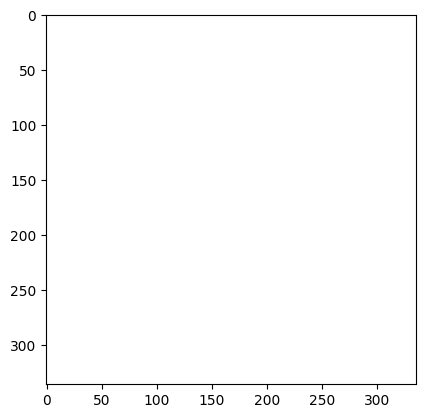

In [180]:
fig = plt.figure()
camera = Camera(fig)  # create the camera object from celluloid

for i in range(standardized_scan1.shape[-1]):
    plt.imshow(standardized_scan1[:,:,i], cmap="bone")
    mask = np.ma.masked_where(preds[i]==0, preds[i])
    plt.imshow(mask, alpha=0.5, cmap="autumn")

    camera.snap()  # Store the current slice
animation = camera.animate()  # create the animation




In [181]:
HTML(animation.to_html5_video())

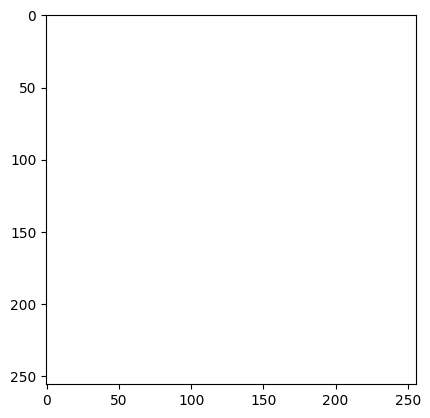

In [182]:
from pathlib import Path
import nibabel as nib
subject2 = Path("/content/drive/MyDrive/Task02_Heart/imagesTs/la_025.nii.gz")
subject2_mri = nib.load(subject2).get_fdata()

subject2_mri = subject2_mri[32:-32, 32:-32]
standardized_scan2 = standardize_volume(normalize_volume(subject2_mri))

preds = []
for i in range(standardized_scan2.shape[-1]):
    slice = standardized_scan2[:,:,i]
    with torch.no_grad():
        pred = model(torch.tensor(slice).unsqueeze(0).unsqueeze(0).float().to("cuda"))[0][0]
        pred = pred > 0.5
    preds.append(pred.cpu())

fig = plt.figure()
camera = Camera(fig)  # create the camera object from celluloid

for i in range(standardized_scan2.shape[-1]):
    plt.imshow(standardized_scan2[:,:,i], cmap="bone")
    mask = np.ma.masked_where(preds[i]==0, preds[i])
    plt.imshow(mask, alpha=0.5, cmap="autumn")

    camera.snap()  # Store the current slice
animation = camera.animate()  # create the animation




In [183]:
HTML(animation.to_html5_video())

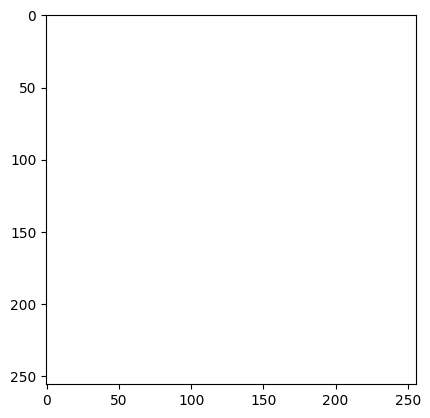

In [185]:
from pathlib import Path
import nibabel as nib
subject3 = Path("/content/drive/MyDrive/Task02_Heart/imagesTs/la_028.nii.gz")
subject3_mri = nib.load(subject3).get_fdata()

subject3_mri = subject3_mri[32:-32, 32:-32]
standardized_scan3 = standardize_volume(normalize_volume(subject3_mri))

preds = []
for i in range(standardized_scan3.shape[-1]):
    slice = standardized_scan3[:,:,i]
    with torch.no_grad():
        pred = model(torch.tensor(slice).unsqueeze(0).unsqueeze(0).float().to("cuda"))[0][0]
        pred = pred > 0.5
    preds.append(pred.cpu())

fig = plt.figure()
camera = Camera(fig)  # create the camera object from celluloid

for i in range(standardized_scan3.shape[-1]):
    plt.imshow(standardized_scan3[:,:,i], cmap="bone")
    mask = np.ma.masked_where(preds[i]==0, preds[i])
    plt.imshow(mask, alpha=0.5, cmap="autumn")

    camera.snap()  # Store the current slice
animation = camera.animate()  # create the animation




In [186]:
HTML(animation.to_html5_video())